# Final Project

Kita akan menggunakan data Walmart Trip Type untuk mencoba mengklasifikasi pelanggan ke jenis jenis belanjaan mereka. Apakah seorang pelanggan sedang belanja untuk makan malam? belanja mingguan? beli hadiah?

Data akan kita ambil dari dua tempat:
- train data https://www.kaggle.com/datasets/thitchen/walmart-trip-type-train
- test data https://www.kaggle.com/datasets/thitchen/walmart-trip-type-test 

Penjelasan tentang data, dan kolom2nya ada di https://www.kaggle.com/competitions/walmart-recruiting-trip-type-classification/data

Kita akan membuat model tipe classification

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

import pickle

In [2]:
# load data
df_data = pd.read_csv("train.csv")
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [3]:
# explore data
triptypes = df_data['TripType'].value_counts()
triptypes = pd.DataFrame(triptypes)
print(len(triptypes.index))
print(triptypes.index.sort_values())


38
Int64Index([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
             21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
             34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999],
           dtype='int64')


<AxesSubplot:>

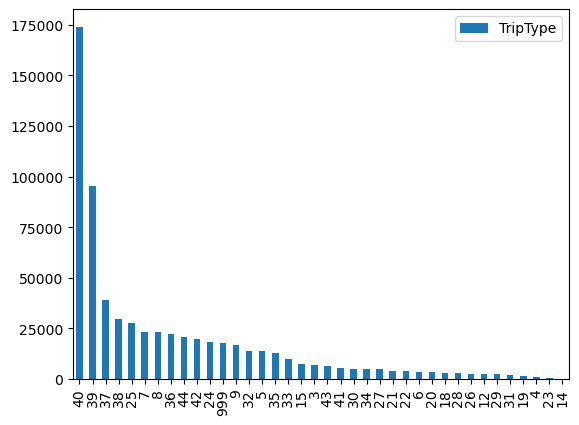

In [4]:
triptypes.plot(kind="bar")

In [5]:
df_data['VisitNumber'].nunique()

95674

In [6]:
df_data['VisitNumber'].value_counts()

72439     209
88011     151
9181      113
60971     112
65792     111
         ... 
59978       1
107116      1
59988       1
162017      1
5           1
Name: VisitNumber, Length: 95674, dtype: int64

untuk missing values, baiknya kita perhatikan kolom per kolom sebelum menentukan cara terbaik untuk handle missing values. Apakah dihapus? diisi mean/ median? diisi sebuah angka fix untuk penanda missing value?

In [7]:
# contoh kita drop missing value
df_data.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [8]:
df_data_dropped = df_data.dropna()

target dari data ini adalah triptype, fitur2nya adalah kolom yang lain. Kita bisa coba cari korelasi antara target ke fitur tertentu.

In [24]:
target = df_data_dropped['TripType']

fitur = df_data_dropped.drop(columns=['TripType'])

In [25]:
fitur.columns

Index(['VisitNumber', 'Weekday', 'Upc', 'ScanCount', 'DepartmentDescription',
       'FinelineNumber'],
      dtype='object')

In [26]:
target

0         999
1          30
2          30
3          26
4          26
         ... 
647049     39
647050     39
647051     39
647052      8
647053      8
Name: TripType, Length: 642925, dtype: int64

In [27]:
df = pd.DataFrame([fitur['VisitNumber'], target]).T
df

,VisitNumber,TripType
0,5,999
1,7,30
2,7,30
3,8,26
4,8,26
...,...,...
647049,191346,39
647050,191346,39
647051,191346,39
647052,191347,8


In [28]:
df_visit_vs_triptype = pd.DataFrame(df.groupby('TripType')['VisitNumber'].value_counts())
df_visit_vs_triptype

VisitNumber
TripType VisitNumber             
3        187894                20
         124866                 7
         107628                 6
         109653                 6
         3845                   5
...                           ...
999      190790                 1
         190805                 1
         190811                 1
         190843                 1
         190930                 1

[94247 rows x 1 columns]

In [29]:
df_visit_vs_triptype.rename(columns={'VisitNumber':'Count'}, inplace=True)
df_visit_vs_triptype

Count
TripType VisitNumber       
3        187894          20
         124866           7
         107628           6
         109653           6
         3845             5
...                     ...
999      190790           1
         190805           1
         190811           1
         190843           1
         190930           1

[94247 rows x 1 columns]

In [30]:
df_visit_vs_triptype.reset_index()

,TripType,VisitNumber,Count
0,3,187894,20
1,3,124866,7
2,3,107628,6
3,3,109653,6
4,3,3845,5
...,...,...,...
94242,999,190790,1
94243,999,190805,1
94244,999,190811,1
94245,999,190843,1


In [31]:
df_visit_vs_triptype['Count'].describe()

count    94247.000000
mean         6.821703
std          8.561956
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max        209.000000
Name: Count, dtype: float64

In [32]:
df_visit_vs_triptype[df_visit_vs_triptype['Count'] > 100]

Count
TripType VisitNumber       
24       72439          209
40       88011          151
         9181           113
         60971          112
         65792          109
         80318          104

kita bisa coba lihat pembagian datanya per TripType untuk mencari apakah ada hubungan VisitNumber tertentu dengan TripType nya. Sepertinya kalau dari sekilas yang kita lihat di atas, VisitNumber 187894 paling mungkin ke TripType 3 - ada 20 kali VisitNumber tersebut masuk ke kategori TripType 3. 

karena banyaknya jumlah kategori unik dari kolom VisitNumber, kita kesulitan melihat signifikan sebuah VisitNumber dalam menentukan TripType. Kita bisa apply teknik untuk mengurangi cardinality dari VisitNumber misal menggunakan minimal value.

In [33]:
fitur['Weekday'].value_counts()

Sunday       133425
Saturday     121434
Friday        95617
Monday        82562
Tuesday       71933
Wednesday     70508
Thursday      67446
Name: Weekday, dtype: int64

untuk kolom Weekday kita perlu encoding, cardinality ok cuma 7 tidak terlalu banyak.

In [34]:
fitur['DepartmentDescription'].value_counts()

GROCERY DRY GOODS         70402
DSD GROCERY               68332
PRODUCE                   51115
DAIRY                     43820
PERSONAL CARE             41969
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
OTHER DEPARTMENTS            29
SEASONAL                     29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

In [35]:
le = LabelEncoder()
fitur['Weekday'] = le.fit_transform(fitur['Weekday'])
print('Weekday')
print(le.classes_)

fitur['DepartmentDescription'] = le.fit_transform(fitur['DepartmentDescription'])
print('DepartmentDescription')
print(le.classes_)

Weekday
['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
DepartmentDescription
['1-HR PHOTO' 'ACCESSORIES' 'AUTOMOTIVE' 'BAKERY' 'BATH AND SHOWER'
 'BEAUTY' 'BEDDING' 'BOOKS AND MAGAZINES' 'BOYS WEAR' 'BRAS & SHAPEWEAR'
 'CAMERAS AND SUPPLIES' 'CANDY, TOBACCO, COOKIES' 'CELEBRATION'
 'COMM BREAD' 'CONCEPT STORES' 'COOK AND DINE' 'DAIRY' 'DSD GROCERY'
 'ELECTRONICS' 'FABRICS AND CRAFTS' 'FINANCIAL SERVICES' 'FROZEN FOODS'
 'FURNITURE' 'GIRLS WEAR, 4-6X  AND 7-14' 'GROCERY DRY GOODS' 'HARDWARE'
 'HEALTH AND BEAUTY AIDS' 'HOME DECOR' 'HOME MANAGEMENT'
 'HORTICULTURE AND ACCESS' 'HOUSEHOLD CHEMICALS/SUPP'
 'HOUSEHOLD PAPER GOODS' 'IMPULSE MERCHANDISE' 'INFANT APPAREL'
 'INFANT CONSUMABLE HARDLINES' 'JEWELRY AND SUNGLASSES' 'LADIES SOCKS'
 'LADIESWEAR' 'LARGE HOUSEHOLD GOODS' 'LAWN AND GARDEN' 'LIQUOR,WINE,BEER'
 'MEAT - FRESH & FROZEN' 'MEDIA AND GAMING' 'MENS WEAR' 'MENSWEAR'
 'OFFICE SUPPLIES' 'OPTICAL - FRAMES' 'OPTICAL - LENSES'
 'OTHER DEPARTMENTS' 'PAINT AND A

In [36]:
# lanjut data exploration

In [37]:
fitur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VisitNumber            642925 non-null  int64  
 1   Weekday                642925 non-null  int32  
 2   Upc                    642925 non-null  float64
 3   ScanCount              642925 non-null  int64  
 4   DepartmentDescription  642925 non-null  int32  
 5   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 45.6 MB


In [39]:
len(target)

642925

In [40]:
# latih model
# pilih model, lalu latih

# misal kita pakai random forest
model = RandomForestClassifier(max_depth=10)
model.fit(fitur, target)

RandomForestClassifier(max_depth=10)

In [41]:
# lihat fitur mana yang penting untuk menebak target
model.feature_importances_

array([0.01757604, 0.01779402, 0.2197189 , 0.15979998, 0.39688819,
       0.18822286])

In [58]:
fi = pd.DataFrame(model.feature_importances_, index=fitur.columns, columns=['Importances'])
fi = fi.sort_values('Importances')
fi

,Importances
VisitNumber,0.017576
Weekday,0.017794
ScanCount,0.159800
FinelineNumber,0.188223
Upc,0.219719
DepartmentDescription,0.396888


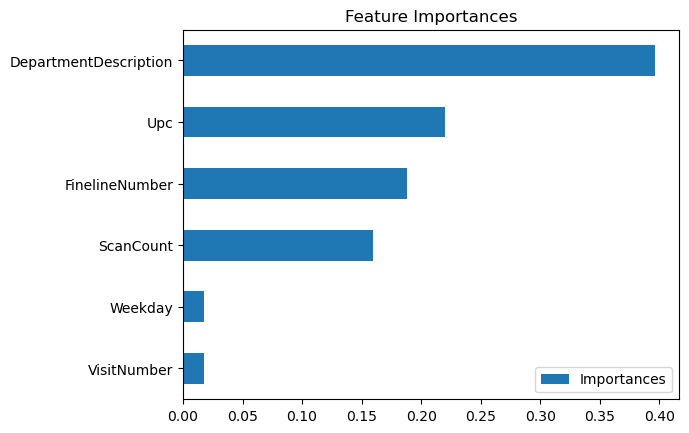

In [61]:
fi.plot(kind="barh")

plt.title("Feature Importances")

plt.show()

ternyata fitur yang paling menentukan TripType adalah DepartmentDescription dan Upc.

In [63]:
# persiapan function untuk visualisasi confusion matrix dan classification report
def visualizeCM(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    n = len(cm) # jumlah label/ kategori

    fig, ax = plt.subplots(figsize=(n+1, n+1))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=range(n))
    ax.set_xlabel("predicted")
    ax.yaxis.set(ticks=range(n))
    ax.set_ylabel("actual")
    ax.set_ylim( n - 0.5, -0.5)
    for i in range(n):
        for j in range(n):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize = 20)
    plt.title("Confusion Matrix")
    plt.show()
    
    print(classification_report(y_test, y_pred))

note: harusnya untuk evaluasi, kita load data test.csv, dan jgn lupa juga perlu di drop missing value, encoding, dan lainnya sampai bentuk sama dengan data training yang kita gunakan.

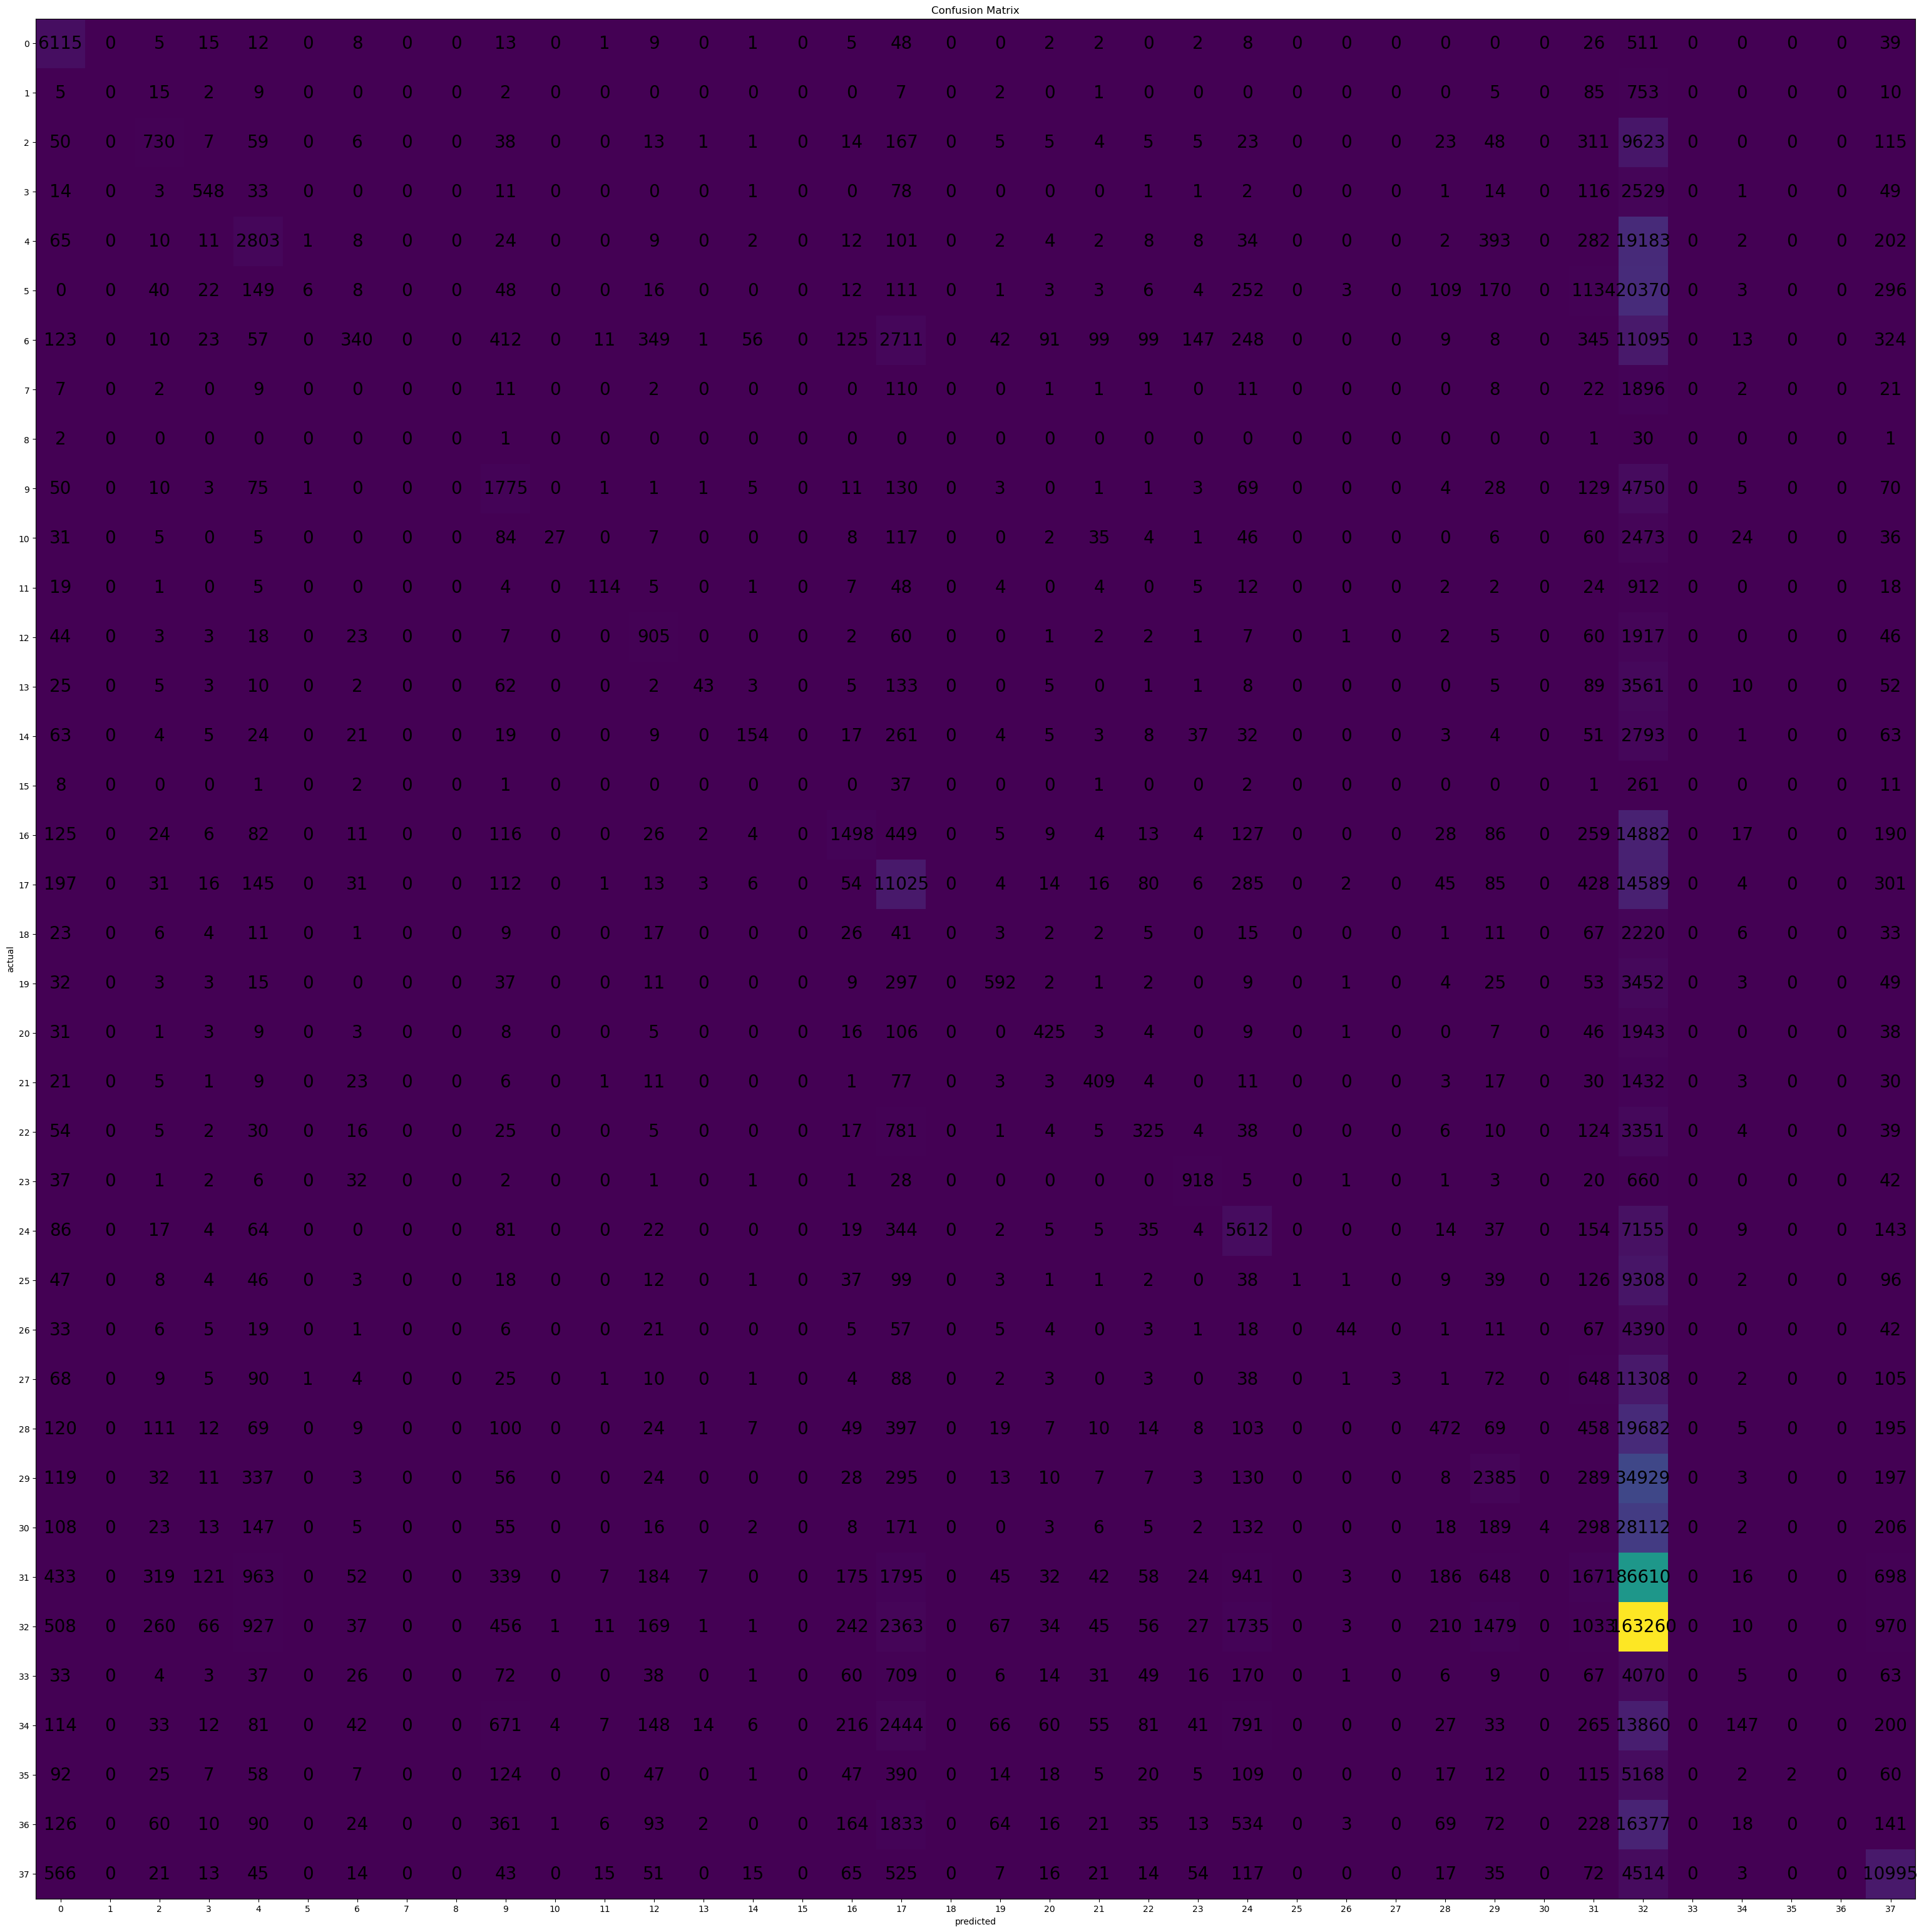

c:\Users\stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.64      0.90      0.75      6822
           4       0.00      0.00      0.00       896
           5       0.40      0.06      0.11     11253
           6       0.57      0.16      0.25      3402
           7       0.43      0.12      0.19     23168
           8       0.67      0.00      0.00     22766
           9       0.45      0.02      0.04     16738
          12       0.00      0.00      0.00      2104
          14       0.00      0.00      0.00        35
          15       0.34      0.25      0.29      7126
          18       0.82      0.01      0.02      2971
          19       0.65      0.10      0.17      1187
          20       0.40      0.29      0.34      3109
          21       0.57      0.01      0.02      4025
          22       0.57      0.04      0.08      3581
          23       0.00      0.00      0.00       325
          24       0.51      0.08      0.14     17967
          25       0.39    

c:\Users\stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# evaluasi

visualizeCM(model, fitur, target)

In [66]:
# save model
filename = 'randomforest_model_walmart.pkl'
pickle.dump(model, open(filename, 'wb'))

In [69]:
fitur.loc[0]

VisitNumber              5.000000e+00
Weekday                  0.000000e+00
Upc                      6.811315e+10
ScanCount               -1.000000e+00
DepartmentDescription    2.000000e+01
FinelineNumber           1.000000e+03
Name: 0, dtype: float64

In [71]:
target.loc[0]

999

In [70]:
# model inference

model.predict([fitur.loc[0]])

c:\Users\stefa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([999], dtype=int64)

kita mencoba memprediksi 1 customer (contohnya customer pertama dari data awal kita) kira2 masuk ke TripType berapa. Kebetulan model kita memprediksi dengan benar.